In [1]:
from datetime import datetime
from goes_rgb.aws_interface import *
from goes_rgb.reader import *
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs  # Plot maps
import cartopy.feature as cfeature


# Vamos a hacer un pipeline simple de descarga de archivos GOES y posterior visualizacion
# Basandonos en el practico 6 de satelitales 

# Primero, vamos a descargar los archivos GOES para una fecha y hora especifica
download_goes_files_for_datetime(datetime(2018, 4, 6, 15),channels=["C15"],product="ABI-L1b-RadF",satellite="noaa-goes16",local_dir="data")

# Listar los archivos descargados
archivos = os.listdir("data")
print("Archivos descargados:")
for archivo in archivos:    
    print(archivo)

Descargando OR_ABI-L1b-RadF-M3C15_G16_s20180961500406_e20180961511178_c20180961511237.nc ...
Listo.
Archivos descargados:
OR_ABI-L1b-RadF-M3C15_G16_s20180961500406_e20180961511178_c20180961511237.nc


In [2]:
# Comenzando el procesamiento

for archivo in archivos:
    print ('Importando la imagen: %s' %archivo)
    imagenobj = open_goes_file(os.path.join("data",archivo))

    metadato = imagenobj.variables
    #breakpoint()
    proyeccion = imagenobj['goes_imager_projection']
    altura=proyeccion.perspective_point_height
    semieje_may = proyeccion.semi_major_axis
    semieje_men = proyeccion.semi_minor_axis
    lon_cen = proyeccion.longitude_of_projection_origin

    # Conversión de arrays de radianes a metros
    x = imagenobj.coords['x'].values * altura
    y = imagenobj.coords['y'].values * altura

    img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527) # De donde sale esto?
    pol = semieje_may*altura/(semieje_may+altura)
    ecu = semieje_men*altura/(semieje_may+altura)

    icanal = int(metadato['band_id'][:])
    print ('Canal %d' %icanal)

    imagen = metadato['Rad'][:].data


    # Nos salteamos la calibracion de la imagen por el momento 
    print ('Calibrando la imagen')
    if icanal >= 7:
        #Parámetros de calibracion
        fk1 = metadato['planck_fk1'].values # DN -> K
        fk2 = metadato['planck_fk2'].values
        bc1 = metadato['planck_bc1'].values
        bc2 = metadato['planck_bc2'].values


        imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2 - 273.15 # K -> C
        Unit = "Temperatura de Brillo [°C]"
    else:
        raise("Not implemented yet")
        pendiente= metadato['Rad'].scale_factor
        ordenada= metadato['Rad'].add_offset
        imag_cal =imagen*pendiente+ordenada
        Unit = "Radiancia ["+metadato['Rad'].units+"]"

    crs = ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)#proyeccion geoestacionaria para Goes16


Importando la imagen: OR_ABI-L1b-RadF-M3C15_G16_s20180961500406_e20180961511178_c20180961511237.nc
Canal 15
Calibrando la imagen


In [3]:
# Coordenada del punto superior izquierdo del recorte (x0, y0) en metros
x0 = -500000
y0 = -2000000

Ny = 1500
Nx = 1500

# Convertir x/y en índices
c0 = np.argmin(np.abs(x - x0))  # índice columna más cercana a x0
f0 = np.argmin(np.abs(y - y0))  # índice fila más cercana a y0

# Extremos del recorte
c1 = c0 + Nx
f1 = f0 + Ny

# Recortes
im_rec = imag_cal[f0:f1, c0:c1]
x_rec = x[c0:c1]
y_rec = y[f0:f1]

# El extent va en orden (xmin, xmax, ymin, ymax)
img_extent = (x_rec[0], x_rec[-1], y_rec[-1], y_rec[0])  # ¡Y en orden invertido para y!

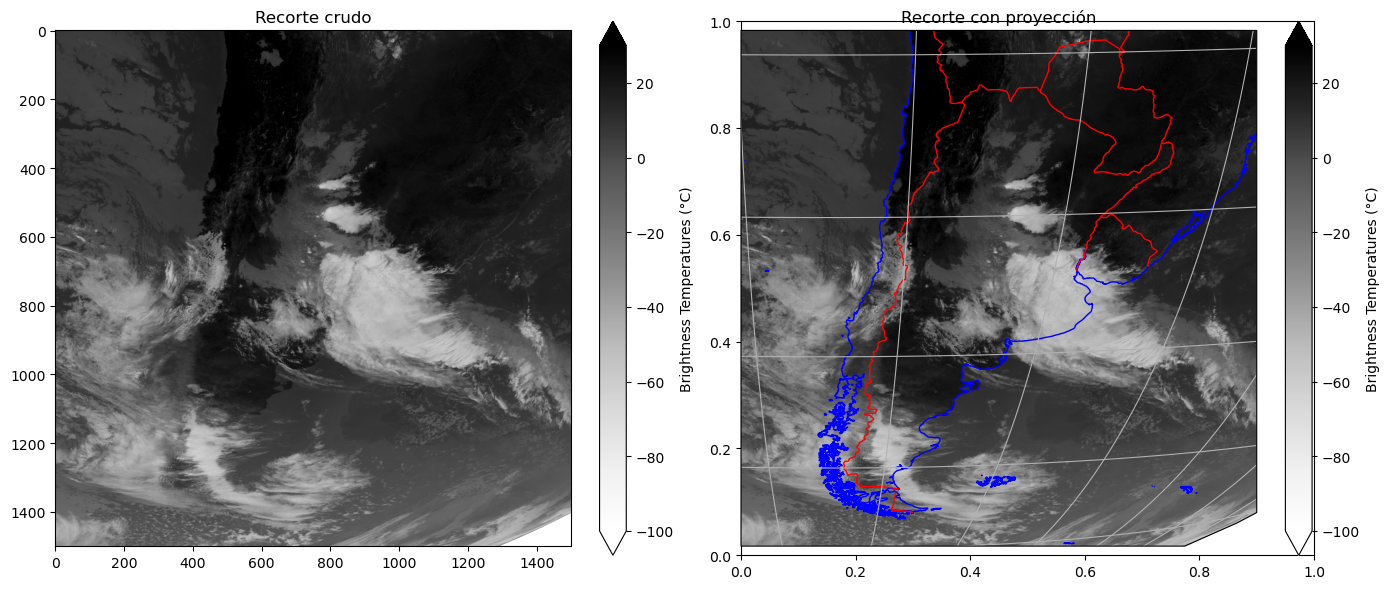

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Primer subplot: imagen recortada simple
img1 = axs[0].imshow(im_rec, vmin=-100., vmax=30., cmap='Greys')
axs[0].set_title("Recorte crudo")
fig.colorbar(img1, ax=axs[0], label='Brightness Temperatures (°C)', extend='both', orientation='vertical', pad=0.05, fraction=0.05)

# Segundo subplot: imagen con proyección
ax2 = plt.subplot(1, 2, 2, projection=crs)
ax2.gridlines()
#importante: no estan alineadas las lineas con lo que se ve en la imagen
ax2.coastlines(resolution='10m', color='blue')
ax2.add_feature(cfeature.BORDERS, edgecolor='red')  # <-- Límites de países en rojo
img2 = ax2.imshow(im_rec, transform=crs, extent=img_extent, vmin=-100., vmax=30., cmap='Greys')
fig.colorbar(img2, ax=ax2, label='Brightness Temperatures (°C)', extend='both', orientation='vertical', pad=0.05, fraction=0.05)
ax2.set_title("Recorte con proyección")

plt.tight_layout()
plt.show()